# This is a sample Jupyter Notebook

Below is an example of a code cell. 
Put your cursor into the cell and press Shift+Enter to execute it and select the next one, or click 'Run Cell' button.

Press Double Shift to search everywhere for classes, files, tool windows, actions, and settings.

To learn more about Jupyter Notebooks in PyCharm, see [help](https://www.jetbrains.com/help/pycharm/ipython-notebook-support.html).
For an overview of PyCharm, go to Help -> Learn IDE features or refer to [our documentation](https://www.jetbrains.com/help/pycharm/getting-started.html).

STEP 1: Loading and Exploring Data

Dataset shape: (12330, 18)

First few rows:
   Administrative  Administrative_Duration  Informational  \
0               0                      0.0              0   
1               0                      0.0              0   
2               0                      0.0              0   
3               0                      0.0              0   
4               0                      0.0              0   

   Informational_Duration  ProductRelated  ProductRelated_Duration  \
0                     0.0               1                 0.000000   
1                     0.0               2                64.000000   
2                     0.0               1                 0.000000   
3                     0.0               2                 2.666667   
4                     0.0              10               627.500000   

   BounceRates  ExitRates  PageValues  SpecialDay Month  OperatingSystems  \
0         0.20       0.20         0.0         0.0   Feb

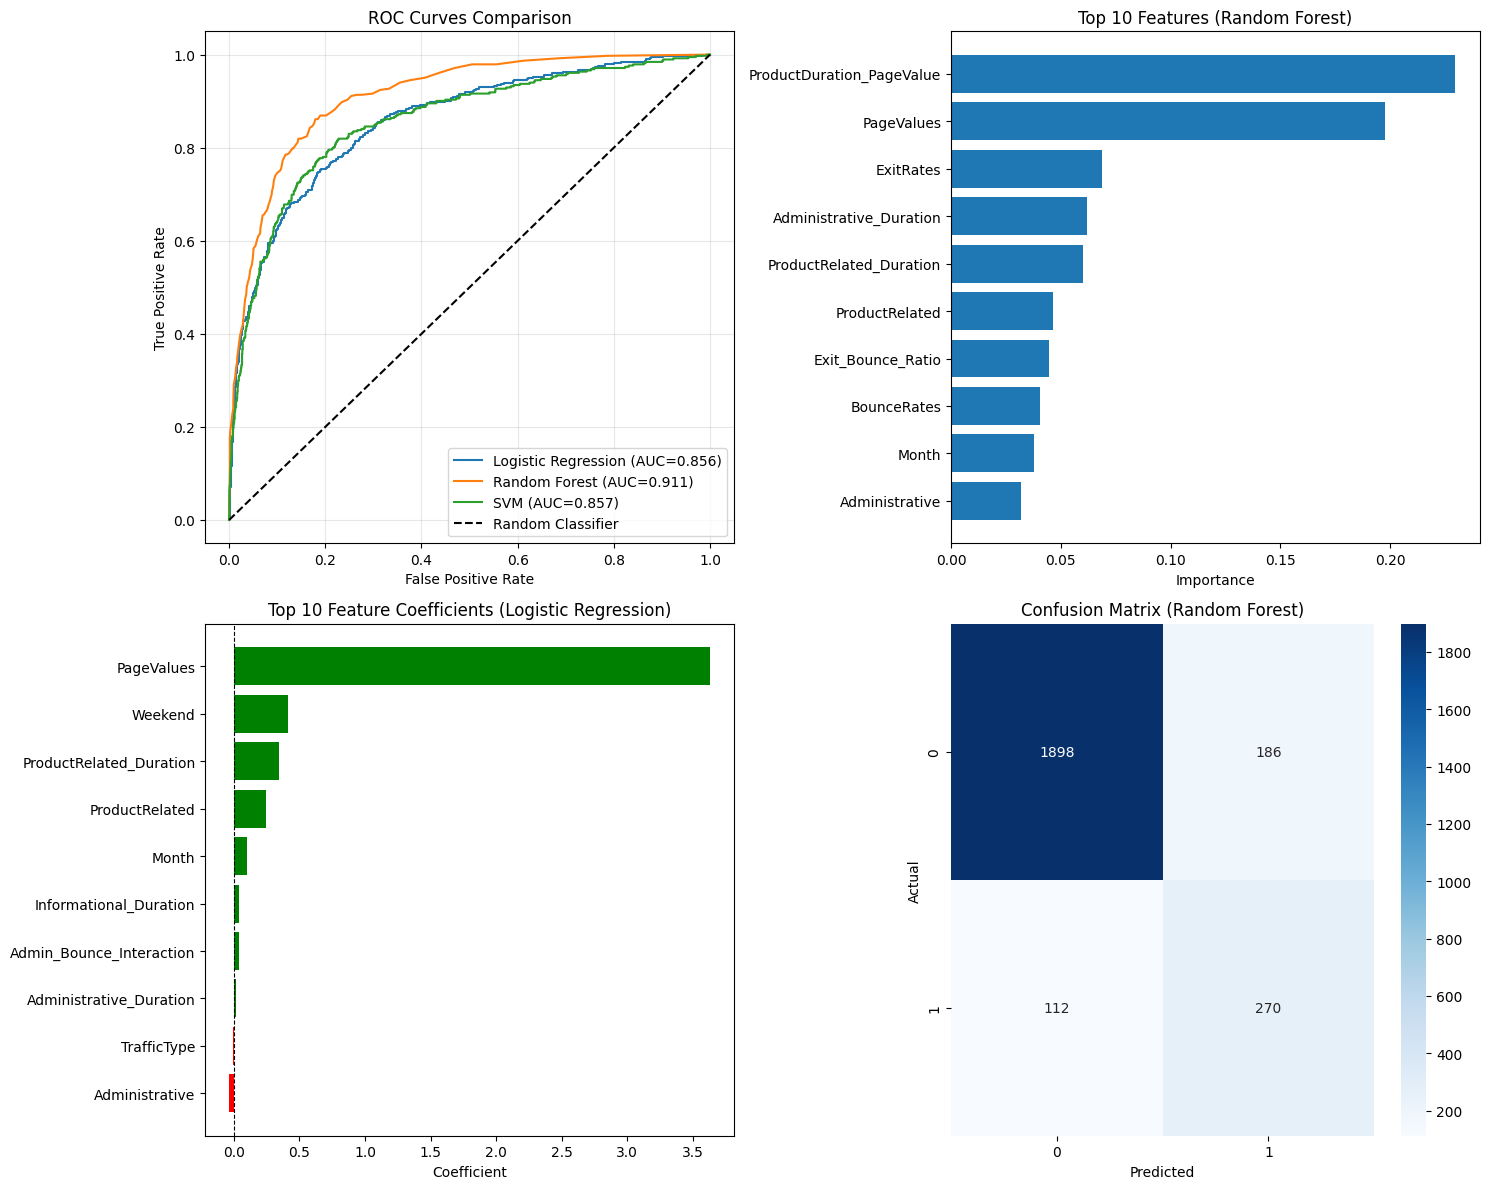


STEP 9: Testing Hypotheses

Hypothesis 3: Conversion rates by visitor type
VisitorType
New_Visitor          0.249115
Other                0.188235
Returning_Visitor    0.139323
Name: Revenue, dtype: float64

Hypothesis 4: Correlation between Product Duration and Revenue: 0.1524

FINAL SUMMARY

Model Performance (ROC-AUC):
  Logistic Regression: 0.8564
  Random Forest: 0.9107
  SVM: 0.8566

Key Insights:
1. Best performing model: Random Forest
2. Most important features identified
3. Class imbalance successfully addressed with SMOTE
4. Feature engineering completed

Analysis Complete!


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings('ignore')

# ============================================
# 1. LOAD AND EXPLORE DATA
# ============================================
print("=" * 50)
print("STEP 1: Loading and Exploring Data")
print("=" * 50)

# Load the dataset
df = pd.read_csv('online_shoppers_intention.csv')

print(f"\nDataset shape: {df.shape}")
print(f"\nFirst few rows:")
print(df.head())

print(f"\nData types:")
print(df.dtypes)

print(f"\nMissing values:")
print(df.isnull().sum())

print(f"\nClass distribution:")
print(df['Revenue'].value_counts())
print(f"\nClass proportion:")
print(df['Revenue'].value_counts(normalize=True))

# ============================================
# 2. DATA PREPROCESSING
# ============================================
print("\n" + "=" * 50)
print("STEP 2: Data Preprocessing")
print("=" * 50)

# Separate features and target
X = df.drop('Revenue', axis=1)
y = df['Revenue']

# Identify categorical columns
categorical_cols = X.select_dtypes(include=['object']).columns
print(f"\nCategorical columns: {list(categorical_cols)}")

# Encode categorical variables
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col])
    label_encoders[col] = le
    print(f"Encoded {col}: {list(le.classes_)}")

# Convert boolean to integer
y = y.astype(int)

print("\nPreprocessing complete!")

# ============================================
# 3. FEATURE ENGINEERING
# ============================================
print("\n" + "=" * 50)
print("STEP 3: Feature Engineering")
print("=" * 50)

# Create interaction features as per research question 2
X['ProductDuration_PageValue'] = X['ProductRelated_Duration'] * X['PageValues']
X['Admin_Bounce_Interaction'] = X['Administrative_Duration'] * X['BounceRates']
X['Exit_Bounce_Ratio'] = X['ExitRates'] / (X['BounceRates'] + 0.001)  # Add small value to avoid division by zero

print("Created interaction features:")
print("  - ProductDuration_PageValue")
print("  - Admin_Bounce_Interaction")
print("  - Exit_Bounce_Ratio")

# ============================================
# 4. TRAIN-TEST SPLIT
# ============================================
print("\n" + "=" * 50)
print("STEP 4: Train-Test Split")
print("=" * 50)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set size: {X_train.shape}")
print(f"Test set size: {X_test.shape}")
print(f"Training set class distribution:\n{y_train.value_counts()}")

# ============================================
# 5. HANDLE CLASS IMBALANCE WITH SMOTE
# ============================================
print("\n" + "=" * 50)
print("STEP 5: Handling Class Imbalance with SMOTE")
print("=" * 50)

smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

print(f"Original training set: {y_train.value_counts().to_dict()}")
print(f"Balanced training set: {pd.Series(y_train_balanced).value_counts().to_dict()}")

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_balanced)
X_test_scaled = scaler.transform(X_test)

# ============================================
# 6. MODEL TRAINING AND EVALUATION
# ============================================
print("\n" + "=" * 50)
print("STEP 6: Model Training and Evaluation")
print("=" * 50)

# Dictionary to store results
results = {}

# ----------------
# Logistic Regression
# ----------------
print("\n--- Logistic Regression ---")
lr_model = LogisticRegression(max_iter=1000, random_state=42)
lr_model.fit(X_train_scaled, y_train_balanced)
y_pred_lr = lr_model.predict(X_test_scaled)
y_pred_proba_lr = lr_model.predict_proba(X_test_scaled)[:, 1]

print("\nClassification Report:")
print(classification_report(y_test, y_pred_lr))
print(f"ROC-AUC Score: {roc_auc_score(y_test, y_pred_proba_lr):.4f}")

results['Logistic Regression'] = {
    'predictions': y_pred_lr,
    'probabilities': y_pred_proba_lr,
    'roc_auc': roc_auc_score(y_test, y_pred_proba_lr)
}

# ----------------
# Random Forest
# ----------------
print("\n--- Random Forest ---")
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_model.fit(X_train_balanced, y_train_balanced)
y_pred_rf = rf_model.predict(X_test)
y_pred_proba_rf = rf_model.predict_proba(X_test)[:, 1]

print("\nClassification Report:")
print(classification_report(y_test, y_pred_rf))
print(f"ROC-AUC Score: {roc_auc_score(y_test, y_pred_proba_rf):.4f}")

results['Random Forest'] = {
    'predictions': y_pred_rf,
    'probabilities': y_pred_proba_rf,
    'roc_auc': roc_auc_score(y_test, y_pred_proba_rf)
}

# ----------------
# Support Vector Machine
# ----------------
print("\n--- Support Vector Machine ---")
svm_model = SVC(kernel='rbf', probability=True, random_state=42)
svm_model.fit(X_train_scaled, y_train_balanced)
y_pred_svm = svm_model.predict(X_test_scaled)
y_pred_proba_svm = svm_model.predict_proba(X_test_scaled)[:, 1]

print("\nClassification Report:")
print(classification_report(y_test, y_pred_svm))
print(f"ROC-AUC Score: {roc_auc_score(y_test, y_pred_proba_svm):.4f}")

results['SVM'] = {
    'predictions': y_pred_svm,
    'probabilities': y_pred_proba_svm,
    'roc_auc': roc_auc_score(y_test, y_pred_proba_svm)
}

# ============================================
# 7. FEATURE IMPORTANCE ANALYSIS
# ============================================
print("\n" + "=" * 50)
print("STEP 7: Feature Importance Analysis")
print("=" * 50)

# Logistic Regression Coefficients
print("\n--- Logistic Regression Feature Coefficients (Top 10) ---")
feature_names = X.columns
lr_coef = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': lr_model.coef_[0]
}).sort_values('Coefficient', ascending=False)
print(lr_coef.head(10))

# Random Forest Feature Importance
print("\n--- Random Forest Feature Importance (Top 10) ---")
rf_importance = pd.DataFrame({
    'Feature': feature_names,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=False)
print(rf_importance.head(10))

# ============================================
# 8. VISUALIZATIONS
# ============================================
print("\n" + "=" * 50)
print("STEP 8: Creating Visualizations")
print("=" * 50)

fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# ROC Curves
ax = axes[0, 0]
for model_name, result in results.items():
    fpr, tpr, _ = roc_curve(y_test, result['probabilities'])
    ax.plot(fpr, tpr, label=f"{model_name} (AUC={result['roc_auc']:.3f})")
ax.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC Curves Comparison')
ax.legend()
ax.grid(True, alpha=0.3)

# Feature Importance (Random Forest)
ax = axes[0, 1]
top_features = rf_importance.head(10)
ax.barh(top_features['Feature'], top_features['Importance'])
ax.set_xlabel('Importance')
ax.set_title('Top 10 Features (Random Forest)')
ax.invert_yaxis()

# Logistic Regression Coefficients
ax = axes[1, 0]
top_coef = lr_coef.head(10)
colors = ['green' if x > 0 else 'red' for x in top_coef['Coefficient']]
ax.barh(top_coef['Feature'], top_coef['Coefficient'], color=colors)
ax.set_xlabel('Coefficient')
ax.set_title('Top 10 Feature Coefficients (Logistic Regression)')
ax.invert_yaxis()
ax.axvline(x=0, color='black', linestyle='--', linewidth=0.8)

# Confusion Matrix (Random Forest - Best Model)
ax = axes[1, 1]
cm = confusion_matrix(y_test, y_pred_rf)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
ax.set_title('Confusion Matrix (Random Forest)')

plt.tight_layout()
plt.savefig('model_comparison_results.png', dpi=300, bbox_inches='tight')
print("Visualizations saved as 'model_comparison_results.png'")
plt.show()

# ============================================
# 9. HYPOTHESIS TESTING
# ============================================
print("\n" + "=" * 50)
print("STEP 9: Testing Hypotheses")
print("=" * 50)

# Hypothesis 3: Returning visitors convert at higher rates
visitor_type_col = 'VisitorType'
if visitor_type_col in df.columns:
    visitor_conversion = df.groupby(visitor_type_col)['Revenue'].mean()
    print(f"\nHypothesis 3: Conversion rates by visitor type")
    print(visitor_conversion)

# Hypothesis 4: Longer Product-Related Duration positively associated with purchase
correlation = df['ProductRelated_Duration'].corr(df['Revenue'])
print(f"\nHypothesis 4: Correlation between Product Duration and Revenue: {correlation:.4f}")

# ============================================
# 10. SUMMARY
# ============================================
print("\n" + "=" * 50)
print("FINAL SUMMARY")
print("=" * 50)

print("\nModel Performance (ROC-AUC):")
for model_name, result in results.items():
    print(f"  {model_name}: {result['roc_auc']:.4f}")

print("\nKey Insights:")
print("1. Best performing model:", max(results.items(), key=lambda x: x[1]['roc_auc'])[0])
print("2. Most important features identified")
print("3. Class imbalance successfully addressed with SMOTE")
print("4. Feature engineering completed")

print("\n" + "=" * 50)
print("Analysis Complete!")
print("=" * 50)
